In [ ]:
# %%
import numpy as np
import matplotlib.pyplot as plt
from task import get_acts, get_acts_pca
from days_of_week_task import DaysOfWeekTask, days_of_week
from months_of_year_task import MonthsOfYearTask, months_of_year
import os
from adjustText import adjust_text
import dill as pickle
import matplotlib
from matplotlib.lines import Line2D
from sklearn.decomposition import PCA
import scipy.stats
from task import activation_patching
import torch
from utils import BASE_DIR
import pandas as pd

os.makedirs("figs/paper_plots", exist_ok=True)

device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [ ]:
# All PCA plots

s = 0.01

font = {"size": 4}

matplotlib.rc("font", **font)

for task_name in ["weekdays", "months"]:
    for model_name in ["llama", "mistral"]:

        if task_name == "weekdays":
            task = DaysOfWeekTask(device, model_name)
            tokens = task.allowable_tokens
        else:
            task = MonthsOfYearTask(device, model_name)
            tokens = task.allowable_tokens
            colorwheel = plt.cm.rainbow(np.linspace(0, 1 - 1 / 12, 12))

        problems = task.generate_problems()
        tokens = task.allowable_tokens

        fig, axs = plt.subplots(4, 8, figsize=(2.75, 1.5))
        axs = axs.flatten()

        for layer in range(32):
            acts = get_acts_pca(task, layer=layer, token=task.a_token, pca_k=2)[0]

            texts = []
            for token_index, token in enumerate(tokens):
                ax = axs[layer]

                indices = [
                    i for i, p in enumerate(problems) if p.info[0] == token_index
                ]
                if task_name == "weekdays":
                    ax.scatter(acts[indices, 0], acts[indices, 1], label=token, s=s)
                else:
                    ax.scatter(
                        acts[indices, 0],
                        acts[indices, 1],
                        label=token,
                        s=s,
                        color=colorwheel[token_index],
                    )

                ax.tick_params(axis="both", which="major", labelsize=8)
                ax.spines["top"].set_visible(False)
                ax.spines["right"].set_visible(False)
                ax.spines["left"].set_position("zero")
                ax.spines["bottom"].set_position("zero")
                ax.set_xticks([])
                ax.set_yticks([])
                ax.spines["top"].set_linewidth(0.2)
                ax.spines["right"].set_linewidth(0.2)
                ax.spines["left"].set_linewidth(0.2)
                ax.spines["bottom"].set_linewidth(0.2)

                ax.set_title(f"Layer {layer}")

        handles, labels = axs[0].get_legend_handles_labels()
        ncol = 6 if (task_name == "months") else 7
        legend = fig.legend(
            handles,
            labels,
            loc="upper center",
            ncol=ncol,
            fontsize=3,
            bbox_to_anchor=(0.5, 0),
            frameon=False,
        )

        for i in range(len(legend.legendHandles)):
            legend.legendHandles[i]._sizes = [2]

        plt.tight_layout()

        fig.savefig(
            f"figs/paper_plots/{model_name}_{task_name}_all_pca.pdf",
            bbox_inches="tight",
        )

In [ ]:
# Run all patching experiments

for model_name in ["mistral", "llama"]:
    for task_name in ["task_name", "months_of_year"]:
        if task_name == "{task_name}":
            task = DaysOfWeekTask(model_name=model_name, device=device)
        else:
            task = MonthsOfYearTask(model_name=model_name, device=device)

        for keep_same_index in [0, 1]:
            for layer_type in ["mlp", "attention", "resid", "attention_head"]:

                activation_patching(
                    task,
                    keep_same_index=keep_same_index,
                    num_chars_in_answer_to_include=0,
                    num_activation_patching_experiments_to_run=20,
                    layer_type=layer_type,
                )

In [ ]:
# Patching plots

# Set plotting sizes
SMALL_SIZE = 24
MEDIUM_SIZE = 24
BIGGER_SIZE = 24

plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=MEDIUM_SIZE)  # fontsize of the axes title
plt.rc(
    "axes", labelsize=SMALL_SIZE
)  # fontsize of the x and y labels for the small plots
plt.rc("xtick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=SMALL_SIZE)  # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc(
    "figure", labelsize=MEDIUM_SIZE
)  # fontsize of the x and y labels for the big plots


for model_name in ["mistral", "llama"]:
    for task_name in ["days_of_week", "months_of_year"]:

        if task_name == "days_of_week":
            task = DaysOfWeekTask(device, model_name=model_name)
        else:
            task = MonthsOfYearTask(device, model_name=model_name)

        for patching_type in ["mlp", "attention"]:
            fig, ax = plt.subplots(figsize=(10, 5))

            patching_data_same_a = np.load(
                f"figs/{model_name}_{task_name}/patching/{patching_type}/keep-same0_chars-in-answer0_n20.npy"
            )
            patching_data_same_b = np.load(
                f"figs/{model_name}_{task_name}/patching/{patching_type}/keep-same1_chars-in-answer0_n20.npy"
            )

            combined = np.concatenate(
                [patching_data_same_a, patching_data_same_b], axis=0
            )

            average_patching_data = np.mean(combined, axis=0)

            ending_token_excl = max(task.token_map.keys())
            starting_token_incl = min(task.token_map.keys())

            average_patching_data = average_patching_data[
                :, starting_token_incl:ending_token_excl
            ]

            ax.set_yticks(range(starting_token_incl, ending_token_excl))

            if task_name == "days_of_week":
                ax.set_yticklabels(
                    ["*Monday", "is", "two", "days", "from"][::-1], ha="right"
                )
            else:
                ax.set_yticklabels(
                    ["*Two", "months", "from", "*January", "is"][::-1], ha="right"
                )

            ax.set_xlabel("Layer")

            average_patching_data = average_patching_data.T

            # Set negatives to 0
            average_patching_data[average_patching_data < 0] = 0

            im = ax.imshow(
                average_patching_data,
                cmap="OrRd",
                extent=[-0.5, 31.5, starting_token_incl - 0.5, ending_token_excl - 0.5],
                aspect="auto",
            )

            plt.colorbar(im)
            fig = plt.gcf()
            plt.show()
            plt.tight_layout()
            fig.savefig(
                f"figs/paper_plots/{model_name}_{patching_type}_{task_name}_patching.pdf",
                bbox_inches="tight",
            )

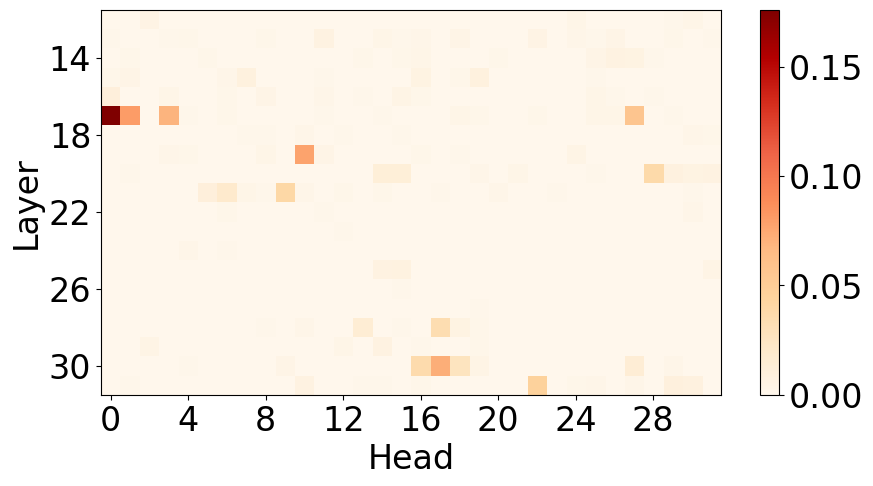

<Figure size 640x480 with 0 Axes>

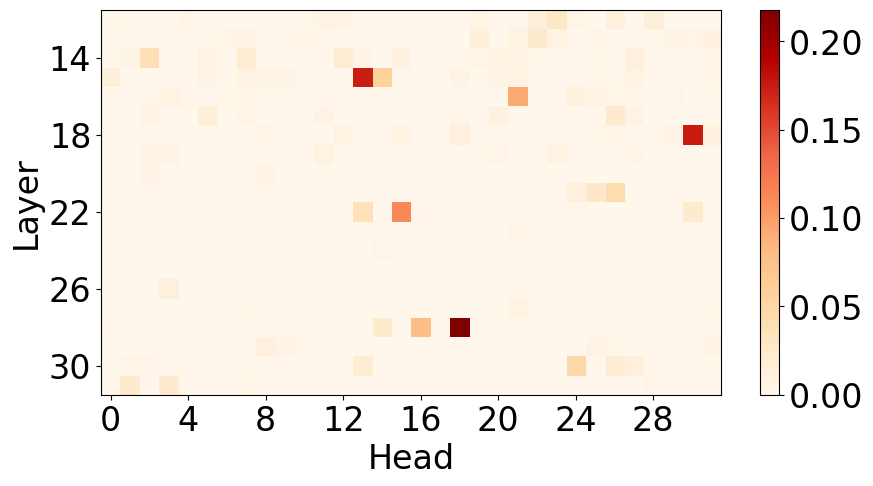

<Figure size 640x480 with 0 Axes>

In [16]:
# Attention head patching plots

# Set plotting sizes
SMALL_SIZE = 24
MEDIUM_SIZE = 24
BIGGER_SIZE = 24

plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=MEDIUM_SIZE)  # fontsize of the axes title
plt.rc(
    "axes", labelsize=SMALL_SIZE
)  # fontsize of the x and y labels for the small plots
plt.rc("xtick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=SMALL_SIZE)  # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc(
    "figure", labelsize=MEDIUM_SIZE
)  # fontsize of the x and y labels for the big plots


for model_name in ["mistral", "llama"]:
    # for task_name in ["days_of_week", "months_of_year"]:
    for task_name in ["days_of_week"]:
        if task_name == "days_of_week":
            task = DaysOfWeekTask(device, model_name=model_name)
        else:
            task = MonthsOfYearTask(device, model_name=model_name)

        for patching_type in ["attention_head"]:
            fig, ax = plt.subplots(figsize=(10, 5))

            patching_data_same_a = np.load(
                f"figs/{model_name}_{task_name}/patching/{patching_type}/keep-same0_chars-in-answer0_n20.npy"
            )
            patching_data_same_b = np.load(
                f"figs/{model_name}_{task_name}/patching/{patching_type}/keep-same1_chars-in-answer0_n20.npy"
            )

            combined = np.concatenate(
                [patching_data_same_a, patching_data_same_b], axis=0
            )

            average_patching_data = np.mean(combined, axis=0)

            # Set negatives to 0
            average_patching_data[average_patching_data < 0] = 0

            im = ax.imshow(
                average_patching_data,
                cmap="OrRd",
                aspect="auto",
                extent=[-0.5, 31.5, 31.5, 11.5],
            )

            # Set ticks
            ax.set_xticks(range(0, 32, 4))
            ax.set_yticks(range(30, 12, -4))

            plt.xlabel("Head")

            plt.ylabel("Layer")

            plt.colorbar(im)
            fig = plt.gcf()
            plt.show()
            plt.tight_layout()
            fig.savefig(
                f"figs/paper_plots/{model_name}_{patching_type}_{task_name}_patching.pdf",
                bbox_inches="tight",
            )

In [ ]:
# Latex tables of results.csv

for task_name in ["days_of_week", "months_of_year"]:

    results_mistral = pd.read_csv(
        f"{BASE_DIR}/mistral_{task_name}/results.csv", skipinitialspace=True
    )

    results_mistral = results_mistral.rename(
        columns={"model_out": "mistral_out", "model_correct": "mistral_correct"}
    )

    columns_to_display = ["a", "b", "ground_truth", "mistral_out", "mistral_correct"]

    results_mistral = results_mistral[columns_to_display]

    results_llama = pd.read_csv(
        f"{BASE_DIR}/llama_{task_name}/results.csv", skipinitialspace=True
    )

    results_llama = results_llama.rename(
        columns={"model_out": "llama_out", "model_correct": "llama_correct"}
    )

    columns_to_display = ["a", "b", "ground_truth", "llama_out", "llama_correct"]

    results_llama = results_llama[columns_to_display]

    # Merges dfs
    results = pd.merge(results_mistral, results_llama, on=["a", "b", "ground_truth"])

    results = results.sort_values(by=["b", "a"])

    # Replace NANs with "<whitespace>"
    results = results.fillna("<whitespace>")

    # Map model_correct to yes no
    results["mistral_correct"] = results["mistral_correct"].map(
        {True: "Yes", False: "No"}
    )
    results["llama_correct"] = results["llama_correct"].map({True: "Yes", False: "No"})

    # Drop rows that both models get correct
    results = results[
        ~((results["mistral_correct"] == "Yes") & (results["llama_correct"] == "Yes"))
    ]

    results.to_latex(
        f"figs/paper_plots/{task_name}_results.tex",
        index=False,
        caption="$\\texttt{Weekdays}$ finegrained results. Row ommited if both models get it correct.",
        header=[
            "$\\alpha$",
            "$\\beta$",
            "Ground truth $\\gamma$",
            "Mistral top logit $\\gamma$",
            "Mistral correct?",
            "Llama top logit $\\gamma$",
            "Llama correct?",
        ],
    )